In [50]:
import simpy
import random
import pandas as pd

# Constants for conversions
KB_TO_MB = 1 / 1024
BIT_TO_MBIT = 1 / 1024

# Simulation Parameters
ENV_RUN_TIME = 1000 
transmission_rate = [500, 1000, 1500, 2000, 2500, 3000]  # in kb/s
num_devices_list = [50, 100, 150, 200, 250, 300]
task_data = [5, 10, 15, 20, 25, 30, 35, 40, 45]  # in Mbit
max_delay = 0.5  # in seconds
device_computing_capacity = [0.5, 1]  # in GHz
num_of_mecs = 10
mec_computing_capacity = 8  # in GHz
transmission_power = 4  # in Watts

class MECServer:
    def __init__(self, env, capacity):
        self.env = env
        self.capacity = capacity
        self.processor = simpy.Resource(env, capacity=int(capacity))

    def process_task(self, task_size, computing_power):
        processing_time = task_size / computing_power
        yield self.env.timeout(processing_time)
        return processing_time

class Device:
    def __init__(self, env, transmission_rate, computing_capacity, mec_servers, logs, num_devices):
        self.env = env
        self.transmission_rate = transmission_rate
        self.computing_capacity = computing_capacity
        self.mec_servers = mec_servers
        self.logs = logs
        self.num_devices = num_devices

    def send_task(self, task_data):
        start_time = self.env.now
        mec = random.choice(self.mec_servers)
        transmission_time = (task_data * BIT_TO_MBIT) / (self.transmission_rate * KB_TO_MB)
        yield self.env.timeout(transmission_time)  # Simulate transmission delay
        energy_consumed = transmission_power * transmission_time
        
        #print(f"Task sent to MEC {mec} by device, starting processing. Time: {self.env.now}")
        
        with mec.processor.request() as req:
            yield req
            processing_time = yield self.env.process(mec.process_task(task_data * BIT_TO_MBIT, mec.capacity))
            total_time = self.env.now - start_time
            self.logs.append({
                'num_devices': self.num_devices,
                'task_data': task_data,
                'transmission_rate': self.transmission_rate,
                'completion_time': total_time,
                'energy_consumed': energy_consumed
            })

# Initialize environment
env = simpy.Environment()
mecs = [MECServer(env, mec_computing_capacity) for _ in range(num_of_mecs)]
logs = []

# Setup devices and start simulation
for num_devices in num_devices_list:
    for rate in transmission_rate:
        devices = [Device(env, rate, random.choice(device_computing_capacity), mecs, logs, num_devices) for _ in range(num_devices)]
        for device in devices:
            task_size = random.choice(task_data)
            env.process(device.send_task(task_size))

env.run(until=ENV_RUN_TIME)

# Convert logs to DataFrame and print
df_logs = pd.DataFrame(logs)
#df_logs.to_csv('metrics_logs.csv')
print(df_logs.head())
# Ensure logs are not empty
if df_logs.empty:
    print("No logs generated. Check simulation parameters and process initialization.")
else:
    print("Logs successfully generated.")


   num_devices  task_data  transmission_rate  completion_time  energy_consumed
0           50          5               3000         0.002277         0.006667
1           50          5               3000         0.002277         0.006667
2          100          5               3000         0.002277         0.006667
3          100          5               3000         0.002277         0.006667
4          100          5               3000         0.002277         0.006667
Logs successfully generated.


In [53]:
import pandas as pd

# Load the DataFrame (assuming it's already created as df_logs from your simulation output)
df_logs = pd.DataFrame(logs)

# Compute the metrics
mean_completion_by_devices = df_logs.groupby('num_devices')['completion_time'].mean()
mean_completion_by_task_data = df_logs.groupby('task_data')['completion_time'].mean()
mean_completion_by_transmission_rate = df_logs.groupby('transmission_rate')['completion_time'].mean()

energy_by_devices = df_logs.groupby('num_devices')['energy_consumed'].sum()
energy_by_task_data = df_logs.groupby('task_data')['energy_consumed'].sum()
energy_by_transmission_rate = df_logs.groupby('transmission_rate')['energy_consumed'].sum()


In [54]:
# Output the results
print("Mean Completion Times by Number of Devices:")
print(mean_completion_by_devices)

Mean Completion Times by Number of Devices:
num_devices
50     0.092787
100    0.095621
150    0.095031
200    0.096768
250    0.097856
300    0.101090
Name: completion_time, dtype: float64


In [55]:
print("\nMean Completion Times by Task Data:")
print(mean_completion_by_task_data)


Mean Completion Times by Task Data:
task_data
5     0.011300
10    0.036316
15    0.059882
20    0.081100
25    0.102954
30    0.122336
35    0.141155
40    0.155459
45    0.168431
Name: completion_time, dtype: float64


In [56]:
print("\nMean Completion Times by Transmission Rate:")
print(mean_completion_by_transmission_rate)


Mean Completion Times by Transmission Rate:
transmission_rate
500     0.186585
1000    0.137932
1500    0.098832
2000    0.070623
2500    0.051924
3000    0.040393
Name: completion_time, dtype: float64


In [57]:
print("\nTotal Energy Consumption by Number of Devices:")
print(energy_by_devices)


Total Energy Consumption by Number of Devices:
num_devices
50      25.477333
100     50.511333
150     73.292667
200     98.114667
250    123.032000
300    146.361333
Name: energy_consumed, dtype: float64


In [58]:
print("\nTotal Energy Consumption by Task Data:")
print(energy_by_task_data)


Total Energy Consumption by Task Data:
task_data
5      11.280000
10     23.321333
15     32.654000
20     44.885333
25     59.430000
30     67.480000
35     81.480000
40     91.738667
45    104.520000
Name: energy_consumed, dtype: float64


In [59]:
print("\nTotal Energy Consumption by Transmission Rate:")
print(energy_by_transmission_rate)


Total Energy Consumption by Transmission Rate:
transmission_rate
500     211.640000
1000    107.060000
1500     69.880000
2000     51.520000
2500     41.216000
3000     35.473333
Name: energy_consumed, dtype: float64


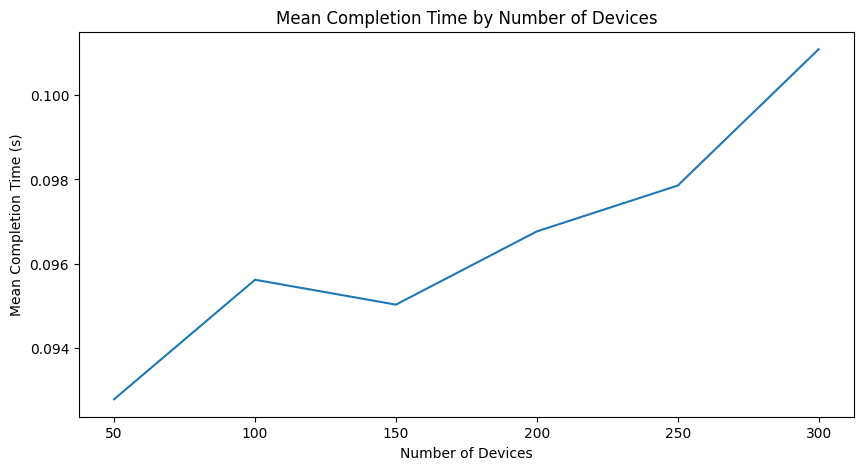

In [52]:
import matplotlib.pyplot as plt

# Plot Mean Completion Time by Number of Devices
plt.figure(figsize=(10, 5))
mean_completion_by_devices.plot(kind='line')
plt.title('Mean Completion Time by Number of Devices')
plt.xlabel('Number of Devices')
plt.ylabel('Mean Completion Time (s)')
plt.show()
